In [1]:
import os

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import feature_extractor as f_extr

Мотивация применения простых методов классификации состоит в том, что 2D сверточные сети ищут визуальные признаки - линии, ключевые точки, структуры и прочее, хотя из примеров разливов видно, что из характерных признаков разлива можно отметить разве что перепад цвета относительно воды. Для обработки всех каналов изображения вместе можно использовать 3D свертки, однако сперва в качестве Baseline решения имеет смысл опробовать простые классификаторы, которые будут делать выводы о принадлжености пикселя изображения к разливу на основе цвета.

# 1. Подготовка данных

In [2]:
test_data_path = '../../../final_dataset_fix/test'

test_images_path = os.path.join(test_data_path, 'images')
test_labels_path = os.path.join(test_data_path, 'labels')

In [3]:
images_loc_paths = os.listdir(test_images_path)

In [4]:
for ilp in images_loc_paths:
    file_name = '.'.join(ilp.split('.')[:-1])
    img_p = os.path.join(test_images_path, ilp)
    lbl_p = os.path.join(test_labels_path, f'{file_name}.jpg')
    
    break

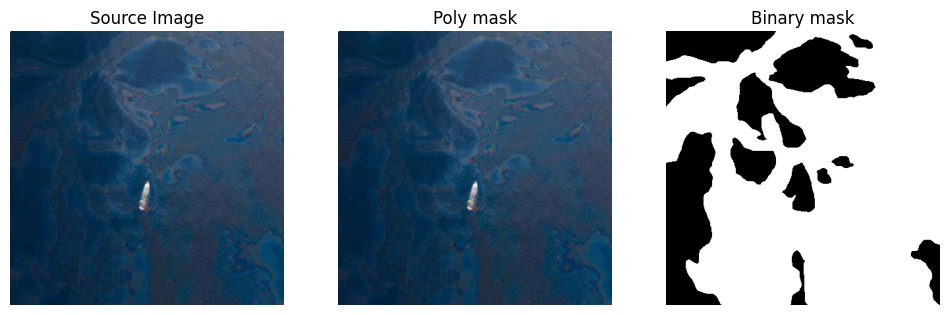

In [5]:
f_extr.vis_label(img_p, lbl_p)

## 1.2. Попиксельное извлечение признаков

In [6]:
df_pixel = f_extr.get_pixelwise_features(img_p, lbl_p)

pd.concat([
    df_pixel.head(3),
    df_pixel.tail(3)
])

,R,G,B,spill
0,225,251,255,0
1,26,52,79,0
2,10,36,63,0
173053,43,71,92,1
173054,42,70,91,1
173055,36,65,83,0


In [7]:
def make_table_from_ds(ds_path, label_type='txt'):
    images_path = os.path.join(ds_path, 'images')
    labels_path = os.path.join(ds_path, 'labels')
    images_loc_paths = os.listdir(images_path)
    df_ds = pd.DataFrame()
    for ilp in tqdm(images_loc_paths, total=len(images_loc_paths)):
        file_name = '.'.join(ilp.split('.')[:-1])
        img_p = os.path.join(labels_path, ilp)
        lbl_p = os.path.join(
            labels_path, f'{file_name}.{label_type}'
        )
        df_ds = pd.concat(
            [df_ds, f_extr.get_pixelwise_features(img_p, lbl_p)]
        )
    return df_ds

In [8]:
# Подготовка датасетов:
train_data_path = '../../../final_dataset_fix/train'
test_data_path = '../../../final_dataset_fix/test'

df_train = make_table_from_ds(train_data_path, label_type='jpg')
df_test = make_table_from_ds(test_data_path, label_type='jpg')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
df_train.to_csv(
    os.path.join(train_data_path, 'train.csv'),
    index=False
)

df_test.to_csv(
    os.path.join(test_data_path, 'test.csv'),
    index=False
)

In [10]:
import numpy as np
import pandas as pd

In [11]:
df_train = pd.read_csv('../../../final_dataset_fix/train/train.csv')
df_test = pd.read_csv('../../../final_dataset_fix/test/test.csv')

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3461120 entries, 0 to 3461119
Data columns (total 4 columns):
 #   Column  Dtype
---  ------  -----
 0   R       int64
 1   G       int64
 2   B       int64
 3   spill   int64
dtypes: int64(4)
memory usage: 105.6 MB


По памяти не так страшно, как могло бы быть, но все равно не очень приятно.

## 1.3. Попиксельные признаки с окрестностью

In [13]:
def get_pixelwise_features_areas(img_p, lbl_p, areas=list):
    """Extracts pixels from image. Returns df."""
    # read image, pnt masks, binary mask:
    image, masks, binary_mask = f_extr.parse_img_label(img_p, lbl_p)
    img_h, img_w, img_ch = image.shape
    max_area = max(areas)
    # extract features:
    areas_scile = np.lib.stride_tricks.sliding_window_view(
        image, (max_area, max_area), axis=(0, 1)
    )
    areas_h, areas_w, _, _, _ = areas_scile.shape
    areas_scile = areas_scile.reshape(
        areas_h*areas_w, img_ch, max_area, max_area
    )
    print(areas_scile.shape)
    return areas_scile
    # df['spill'] = binary_mask.flatten().astype(int)
    # return df

In [14]:
t = get_pixelwise_features_areas(img_p, lbl_p, areas=[7])

(168100, 3, 7, 7)


In [15]:
t.shape

(168100, 3, 7, 7)

In [16]:
def make_areas_filter(areas: list):
    max_area = max(areas)

    areas_mask = np.stack([
        np.pad(
            np.ones((a_size, a_size)),
            ((max_area - a_size) // 2, (max_area - a_size) // 2)
        )
        for a_size in areas
    ]).astype(int)
    
    return areas_mask

In [17]:
areas_filter = make_areas_filter([3, 5, 7])
areas_filter.shape

(3, 7, 7)

In [18]:
t[0].shape

(3, 7, 7)

In [19]:
areas_filter.shape

(3, 7, 7)

In [20]:
# first window, first channel:
t[0][0] * areas_filter

# нужно сдедать repeat, чтобы размер был как для каждого канала

array([[[  0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   6,  10,   6,   0,   0],
        [  0,   0,  20,   5,   6,   0,   0],
        [  0,   0,   6,   7,   8,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0,   0,   0],
        [  0,  17,  13,   5,  11,  13,   0],
        [  0,  14,   6,  10,   6,   5,   0],
        [  0,  15,  20,   5,   6,  10,   0],
        [  0,  10,   6,   7,   8,  11,   0],
        [  0,  18,  10,  12,  13,  13,   0],
        [  0,   0,   0,   0,   0,   0,   0]],

       [[225,  26,  10,   9,  11,  10,   9],
        [ 13,  17,  13,   5,  11,  13,   5],
        [ 18,  14,   6,  10,   6,   5,  11],
        [ 14,  15,  20,   5,   6,  10,  10],
        [  7,  10,   6,   7,   8,  11,  10],
        [ 16,  18,  10,  12,  13,  13,   4],
        [  4,   4,   9,   9,  10,  14,  10]]])

In [21]:
areas_filter_rep = np.stack([areas_filter, areas_filter, areas_filter])
areas_filter_rep.shape

(3, 3, 7, 7)

In [22]:
# здесь к каждому каналу применятеся окно того же размер
t[0] * areas_filter_rep

array([[[[  0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   6,  10,   6,   0,   0],
         [  0,   0,  20,   5,   6,   0,   0],
         [  0,   0,   6,   7,   8,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0]],

        [[  0,   0,   0,   0,   0,   0,   0],
         [  0,  43,  39,  31,  38,  40,   0],
         [  0,  40,  32,  36,  33,  32,   0],
         [  0,  41,  46,  31,  33,  37,   0],
         [  0,  36,  32,  33,  35,  38,   0],
         [  0,  44,  36,  38,  40,  40,   0],
         [  0,   0,   0,   0,   0,   0,   0]],

        [[255,  79,  63,  62,  65,  64,  65],
         [ 66,  70,  66,  58,  65,  67,  61],
         [ 71,  67,  59,  63,  60,  59,  67],
         [ 67,  68,  73,  58,  60,  64,  66],
         [ 60,  63,  59,  60,  62,  65,  66],
         [ 69,  71,  63,  65,  67,  67,  60],
         [ 57,  57,  62,  62,  64,  68,  66]]],


       [[[  0,   0,   0,  

# 2. Модели

In [23]:
from metrics import masks_iou

In [25]:
def calc_iou_dataset(ds_path, model, lbl_type='txt'):
    images_path = os.path.join(ds_path, 'images')
    labels_path = os.path.join(ds_path, 'labels')
    images_loc_paths = os.listdir(images_path)
    iou_total = 0
    for ilp in images_loc_paths:
        file_name = '.'.join(ilp.split('.')[:-1])
        img_p = os.path.join(images_path, ilp)
        lbl_p = os.path.join(labels_path, f'{file_name}.{lbl_type}')
        img, _, true_bin_mask = f_extr.parse_img_label(img_p, lbl_p)
        pred_bin_mask = model.predict(img)
        iou_total += masks_iou(true_bin_mask, pred_bin_mask)
    res = iou_total / len(images_loc_paths)
    return round(res, 3)

## Логистическая регрессия

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [75]:
logistic_regression = LogisticRegression()

In [76]:
logistic_regression.fit(
    df_train[['R', 'G', 'B']], df_train['spill']
)

LogisticRegression()

In [77]:
class LogReg:
    def __init__(self, model):
        self.model = model
        
    def predict(self, image):
        t_img_h, t_img_w, t_img_ch = image.shape
        img_df = pd.DataFrame(
            image.reshape(t_img_h * t_img_w, t_img_ch),
            columns=['R', 'G', 'B']
        )
        pred = self.model.predict(img_df[['R', 'G', 'B']])
        return pred.reshape(t_img_h, t_img_w, 1)

In [78]:
log_reg = LogReg(logistic_regression)

In [79]:
# test
y_pred = logistic_regression.predict(df_test[['R', 'G', 'B']])
round(f1_score(df_test['spill'], y_pred), 3)

1.0

In [80]:
# train
y_pred_train = logistic_regression.predict(df_train[['R', 'G', 'B']])
round(f1_score(df_train['spill'], y_pred_train), 3)

1.0

In [86]:
test_image = cv2.cvtColor(
    # cv2.imread('../../../final_dataset_fix/train/images/28.jpg'),
    # cv2.imread('../../../final_dataset_fix/test/images/23.jpg'),
    cv2.imread('test_image.jpg'),
    cv2.COLOR_BGR2RGB
)

In [87]:
test_img_pred_mask = log_reg.predict(test_image)

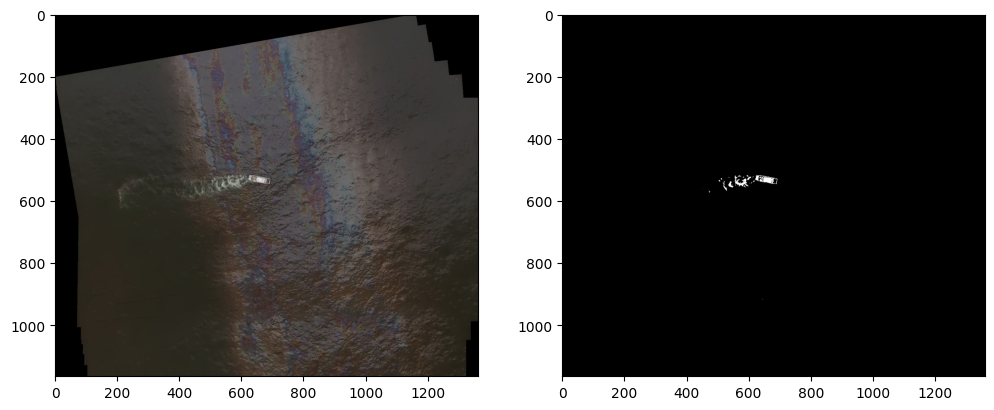

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].imshow(test_image)
ax[1].imshow(test_img_pred_mask*255, 'gray')

plt.show()

In [84]:
# test
calc_iou_dataset(
    '../../../final_dataset_fix/test',
    log_reg,
    lbl_type='jpg'
)

0.074

In [85]:
# train
calc_iou_dataset(
    '../../../final_dataset_fix/train',
    log_reg,
    lbl_type='jpg'
)

0.267

Сравнение моделей:

| Model | Optimizer | Lr | Loss Function | Epochs | Data | IoU
|:------|:----------|:---|:--------------|:-------|:-----|:---
|PW Log Reg|SGD|0.0001|Log|100|Small|0.074
| Unet | Adam | 0.001 | BCE | 30 | Small | 0.472
| Unet | AdamW | 0.001 | BCE | 30 | Small | 0.411
| Unet | AdamW | 0.001 | BCE | 90 | Big | 0.423
| MMSeg | Adam | 0.001 | BCE | 1000 | Large | 0.524